In [1]:
from scipy.stats import wilcoxon
import numpy as np
import pandas as pd
import re
import krippendorff
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from results_functions import Squared_diff_list, hist_dist, bootstrap_mse_models,plot_bootstrapped_msd_humanVSmodels, bootstrap_alpha, plot_CI, mean_diff_models_vs_human, bootstrap_mean_diff_CI,plot_mean_diff_models_vs_human

In [3]:
#Fetching Data
df_mikkel = pd.read_json("../self_annotation/annotations_mikkel.json")
df_david = pd.read_json("../self_annotation/annotations_david.json")
df_carl = pd.read_json("../self_annotation/annotations_carl.json")

#Fix of dataframe
def parse_label_string(label_str):
    return re.findall(r"'(.*?)'", label_str)

df_mikkel['original_label'] = df_mikkel['original_label'].apply(parse_label_string)

#Check:
df_mikkel["original_label"].iloc[0][0]

'None'

In [4]:
# Fetching model results
df_models = pd.read_json("../test/final_results.json", lines=True)

model_data = defaultdict(list)

raw_cols = [col for col in df_models.columns if col.startswith("raw")]
for col in raw_cols:
    model_data[col] = df_models[col].tolist()

In [5]:
# Preparing data and setting variables 

num_encoder = {'None': 0,
               'Minimal': 1,
               'Basic': 2,
               'Good': 3,
               'Excellent': 4,
               '❗ Problematic Content ❗': 0, # for security
            }

N = len(df_mikkel)
R = 5 #number of ratings

score_dict = {}
score_data = []

for i in range(len(df_mikkel)):
    labels = [df_carl["our_label"].iloc[i], df_mikkel["our_label"].iloc[i], df_david["our_label"].iloc[i]] + df_mikkel["original_label"].iloc[i]
    scores = [num_encoder[label] for label in labels]
    id_ = df_mikkel["id"].iloc[i]
    score_dict[id_] = scores #dict of lists
    score_data.append(scores) # list of lists

/var/folders/t1/pvhvgdyj15g798qw31m8tb8c0000gn/T/ipykernel_77115/2563187721.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


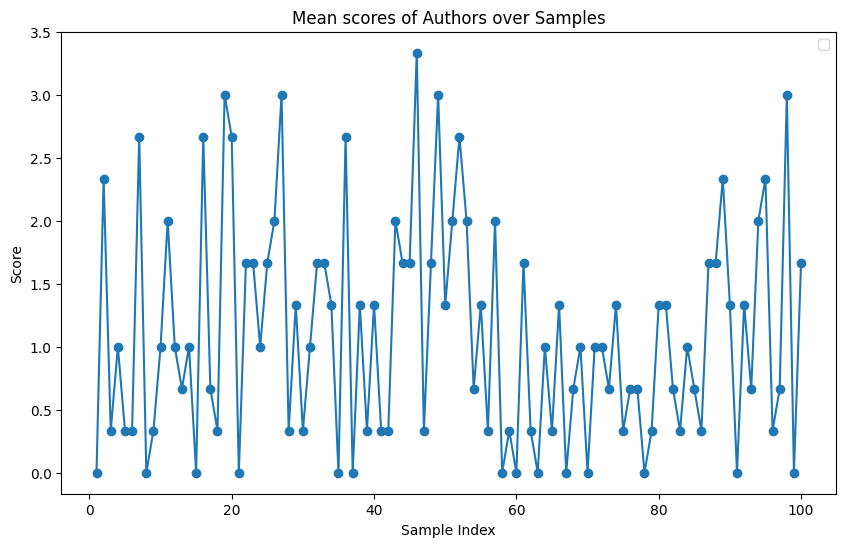

In [6]:
# Plotting the average score to look for trends
our_score_data = [scores[:3] for scores in score_data]  # Only our labels (Mikkel, David, Carl)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N + 1), [np.mean(scores) for scores in our_score_data], marker='o')
plt.title('Mean scores of Authors over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.legend()
plt.show()

____

## Global aggreement: MSD and Krippendorffs $\alpha$

### MSD

In [7]:

def Mean_Squared_Diff(score_data): # <-- list of lists

    SD_list = []

    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return np.mean(SD_list)

MSD = np.mean(Mean_Squared_Diff(score_data))

MSD

np.float64(1.2646666666666666)

### Krippendorff's $\alpha$

In [8]:
# Alpha calculated with library
def K_alpha(score_data,datatype):
    reliability_data = np.array(score_data).T 
    alpha = krippendorff.alpha(reliability_data=reliability_data, value_domain=list(range(R)), level_of_measurement=datatype)
    return alpha

alpha = K_alpha(score_data,"interval")
alpha

np.float64(0.4401220957303449)

In [9]:
#Alpha calculated by hand assuming equal intervals:

D_o = MSD

# All annotation scores
all_scores = np.asarray(score_data).flatten()


label_counts = Counter(all_scores)  #dict
labels = list(range(R))
n_total = len(all_scores)  # total annotations

# Calculate D_e
De_numerator = 0
for i in range(R):
    for j in range(i + 1, R):
        a = labels[i]
        b = labels[j]
        n_a = label_counts[a]
        n_b = label_counts[b]
        delta = (a - b) ** 2
        De_numerator += n_a * n_b * delta

D_e =  De_numerator * 2 / (n_total * (n_total - 1))

alpha_simplifed = 1 - D_o / D_e
alpha_simplifed

np.float64(0.4401220957303449)

In [10]:
#Comparing to ordinal delta function
alpha_ordinal = K_alpha(score_data, "ordinal")
diff_alpha = alpha - alpha_ordinal

print(f"alpha (interval): {alpha}")
print(f"alpha (ordinal): {alpha_ordinal}")
print(f"Difference (alpha - alpha_ordinal): {diff_alpha}")

alpha (interval): 0.4401220957303449
alpha (ordinal): 0.44388382293447715
Difference (alpha - alpha_ordinal): -0.003761727204132259


_______
## Comparing annotator-groups

In [11]:
n = 3 #number of author annotators

human_data = {"author": [scores[:n] for scores in score_data],
        "fineweb": [scores[n:] for scores in score_data],
        "all": score_data}

agreement = {}
for name,list_score in human_data.items():
    agreement[name] = (Mean_Squared_Diff(list_score), 
                       K_alpha(list_score, "ordinal"),
                       np.mean([np.mean(scores) for scores in list_score])
                       )
agreement

{'author': (np.float64(0.9666666666666666),
  np.float64(0.560818764498379),
  np.float64(1.106666666666667)),
 'fineweb': (np.float64(1.6066666666666665),
  np.float64(0.3381319866159098),
  np.float64(0.9500000000000002)),
 'all': (np.float64(1.2646666666666666),
  np.float64(0.44388382293447715),
  np.float64(1.0283333333333333))}

### Statistic tests

In [12]:
# Normality for MSD
from scipy.stats import shapiro
# Function to calculate a list of mean squared differences for each sample was imported from results_functions.py

# Shapiro Wilk
stat, p_aut = shapiro(Squared_diff_list(human_data["author"]))
print(f"Shapiro-Wilk p 'author' = {p_aut}")

stat, p_fine = shapiro(Squared_diff_list(human_data["fineweb"]))
print(f"Shapiro-Wilk p 'fineweb' = {p_fine}")

np.mean(Squared_diff_list(score_data))

Shapiro-Wilk p 'author' = 5.730903158670814e-13
Shapiro-Wilk p 'fineweb' = 2.761921713048834e-10


np.float64(1.2646666666666666)

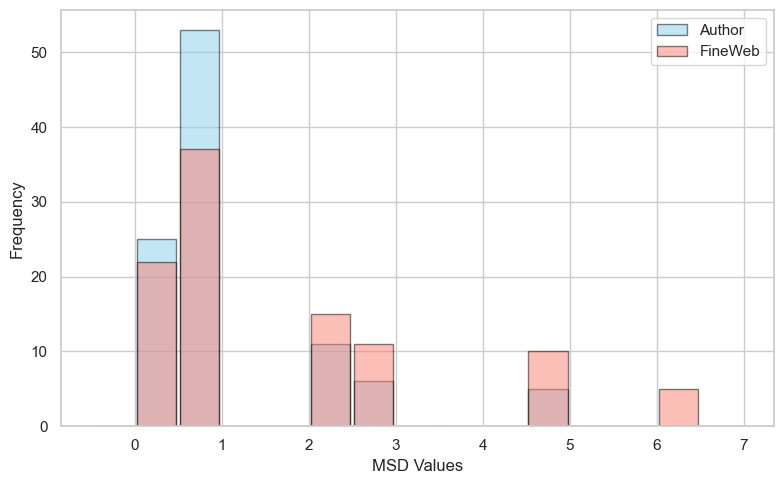

In [13]:
# imported from functions_results.py
hist_dist(human_data["author"],human_data["fineweb"], "Author", "FineWeb", "msd")

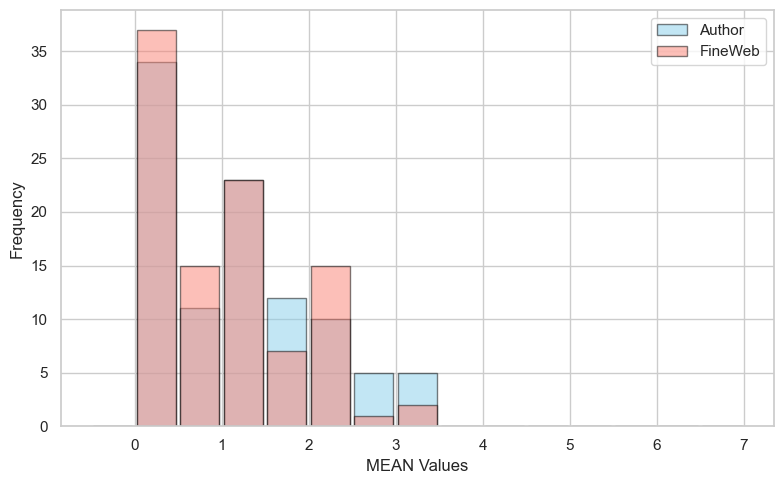

In [14]:
hist_dist(human_data["author"],human_data["fineweb"], "Author", "FineWeb", "mean")

In [15]:
def wilcoxon_test(sample1, sample2 , type):
    if type == "msd":
        list1 = Squared_diff_list(sample1)
        list2 = Squared_diff_list(sample2)

    elif type == "mean":
        if sample1[0] is float:
            list1 = sample1
        else:
            list1 = [np.mean(scores) for scores in sample1]
        if sample2[0] is float:
            list2 = sample2
        else:
            list2 = [np.mean(scores) for scores in sample2]
    else:
        return "Error"
    
    return wilcoxon(list1,list2) # returns --> wilcoxon_stat, wilcoxon_p$

In [16]:
# Paired test
wilcoxon_stat_msd, wilcoxon_p_msd = wilcoxon_test(human_data["author"], human_data["fineweb"], "msd")
wilcoxon_stat_mean, wilcoxon_p_mean = wilcoxon_test(human_data["author"], human_data["fineweb"], "mean")

print(f"Wilcoxon p-value (MSD): {wilcoxon_p_msd}")
print(f"Wilcoxon p-value (Mean): {wilcoxon_p_mean}")

Wilcoxon p-value (MSD): 0.0019335420818070834
Wilcoxon p-value (Mean): 0.024049874094710655


___
## Comparing our trained models

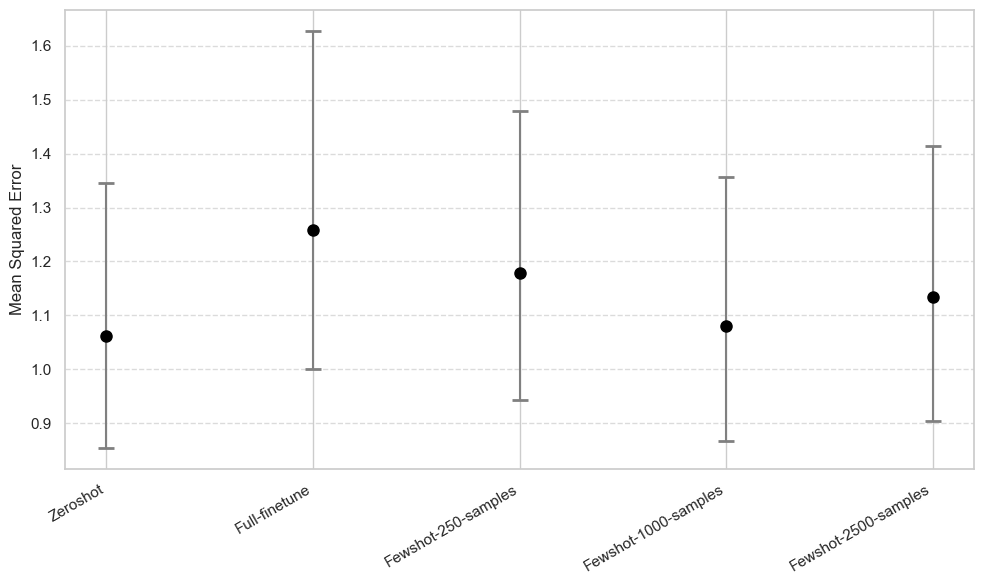

In [17]:
# Bootstrap confidence intervals for model MSEs
y_human = [np.mean(scores) for scores in score_data]

#impoorted from results_functions.py
bootstrap_mse_models(model_data,y_human,10000)

In [18]:
from scipy.stats import ttest_rel,wilcoxon

p_values = np.zeros((len(model_data), len(model_data)))
shapiro_results = {}

for (name1, model_scores1),i in zip(model_data.items(),range(len(model_data))):
    shapiro_stat, p_shapiro = shapiro(model_scores1)
    shapiro_results[name1] = p_shapiro

    for (name, model_scores),j in zip(model_data.items(),range(len(model_data))):
        if name1 == name:
            continue

        y_human = np.mean([np.mean(scores) for scores in score_data])
        y_pred1 = np.array(model_scores1)
        y_pred2 = np.array(model_scores)

        errors1 = (y_human - y_pred1)**2
        errors2 = (y_human - y_pred2)**2

        t_stat, p_value = ttest_rel(errors1, errors2)
        p_values[i, j] = p_value

In [19]:
print("Shapiro-Wilk p-values for models:")
for model_name, p_value in shapiro_results.items():
    print(f"{model_name}: {p_value}")

Shapiro-Wilk p-values for models:
raw_prediction_zeroshot: 0.677019941373097
raw_prediction_Full-finetune: 0.35936400184304673
raw_prediction_fewshot-250-samples: 0.6667966034322942
raw_prediction_fewshot-1000-samples: 0.6708629002098552
raw_prediction_fewshot-2500-samples: 0.6578051998240472


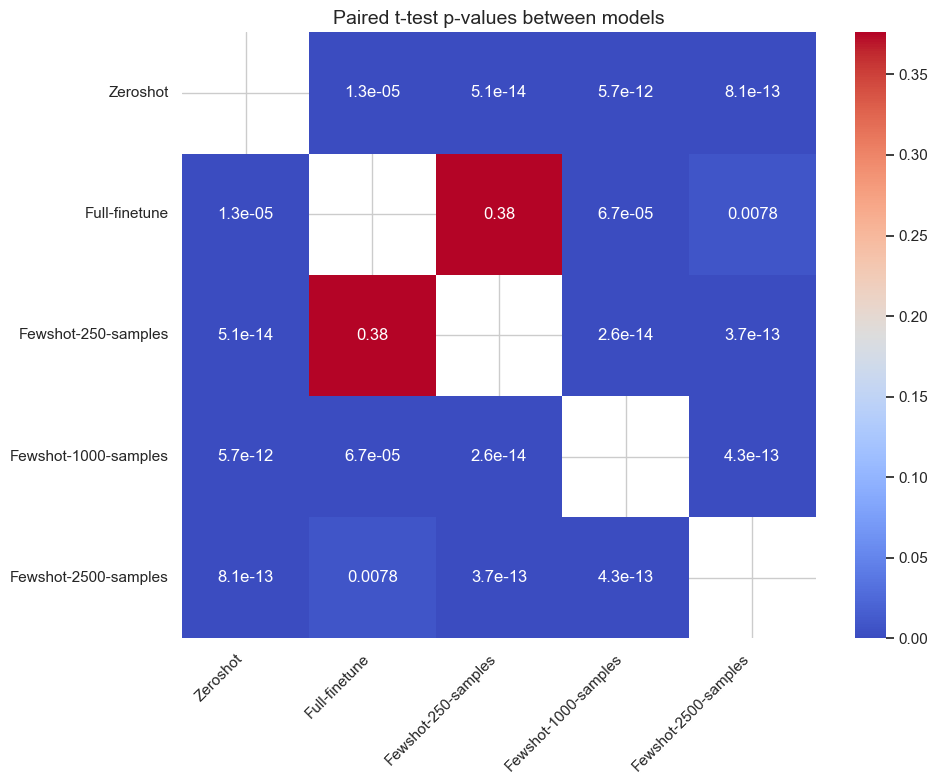

In [20]:
model_labels = [name[15:].capitalize() for name in model_data.keys()]

plt.figure(figsize=(10, 8))  # Wider and taller figure
sns.heatmap(p_values, annot=True, cmap="coolwarm", 
            mask=np.eye(len(p_values)), 
            xticklabels=model_labels, 
            yticklabels=model_labels)

plt.title("Paired t-test p-values between models", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()                   # Prevent label cutoff
plt.show()

All models predicted significantly different scores than the human mean. (p-value > 0.05).

___
### Comparing Models to Human scores

In [21]:
data_model_human = model_data.copy() 
data_model_human["Human"] = score_data

MEAN

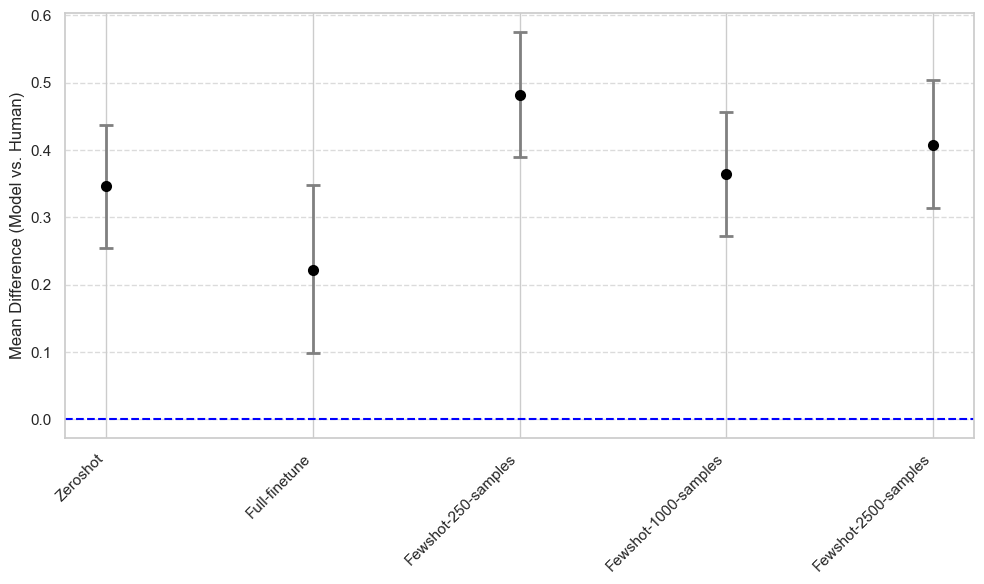

In [22]:
# Plotting the bootstrapped CIs of the differences between model predictions and mean human annotations:
plot_mean_diff_models_vs_human(data_model_human)

DISAGREEMENT

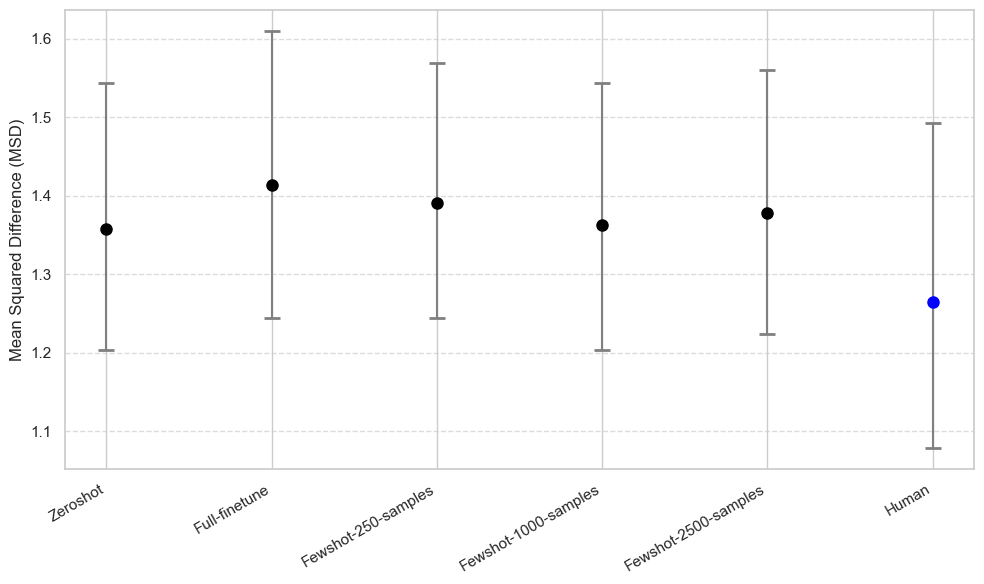

In [23]:
# Plotting the bootstrapped CI of mean MSDs of human annotations + each models predictions separately:
plot_bootstrapped_msd_humanVSmodels(data_model_human)

In [24]:
# Statistical test

# first
# Checking for normality of human scores 
shapiro_stat, shapiro_p = shapiro([np.mean(scores) for scores in score_data])
float(shapiro_p)

9.851985222541103e-05

No significance (p_shapiro < 0.05)  --> non-parametric tests

In [33]:
# MSD comparison with human scores

for name, scores in model_data.items():
    data_model_and_all = [[scores[i]] + human_data["all"][i] for i in range(len(scores))]
    wilcoxon_stat, wilcoxon_p = wilcoxon_test(score_data, data_model_and_all, "msd")
    MSD_score = Mean_Squared_Diff(data_model_and_all) - Mean_Squared_Diff(score_data)
    print(f"Model {name}, Change in MSD: {MSD_score}, Wilcoxon p-value: {wilcoxon_p}")

Model raw_prediction_zeroshot, Change in MSD: 0.09278269560015784, Wilcoxon p-value: 0.3271243358754563
Model raw_prediction_Full-finetune, Change in MSD: 0.1486588906228825, Wilcoxon p-value: 0.14112810604636963
Model raw_prediction_fewshot-250-samples, Change in MSD: 0.12603348191189734, Wilcoxon p-value: 0.10535026094391692
Model raw_prediction_fewshot-1000-samples, Change in MSD: 0.09789174133009348, Wilcoxon p-value: 0.27573562109341054
Model raw_prediction_fewshot-2500-samples, Change in MSD: 0.11301223199703903, Wilcoxon p-value: 0.19136101989145005


No models significantly raise the inter-annotator disagreement (MSD) when added the human annotators (p-values > 0.05). The MSD before the models where added was 1.26. However, more test data might reduce the margins ofthe CIs and show otherwise.

In [26]:
CI_data = []
model_names = []
for name, predictions in data_model_human.items():
    model_names.append(name[15:].capitalize() if name != "Human" else "Human")

    if name != "Human":
        # Add model predictions to human ratings per sample
        combined = [np.append(score_data[i], predictions[i]) for i in range(len(predictions))]
    else:
        combined = score_data
    
    # from results_functions.py
    CI_data.append(bootstrap_alpha(combined))

100%|██████████| 1000/1000 [00:00<00:00, 13555.81it/s]


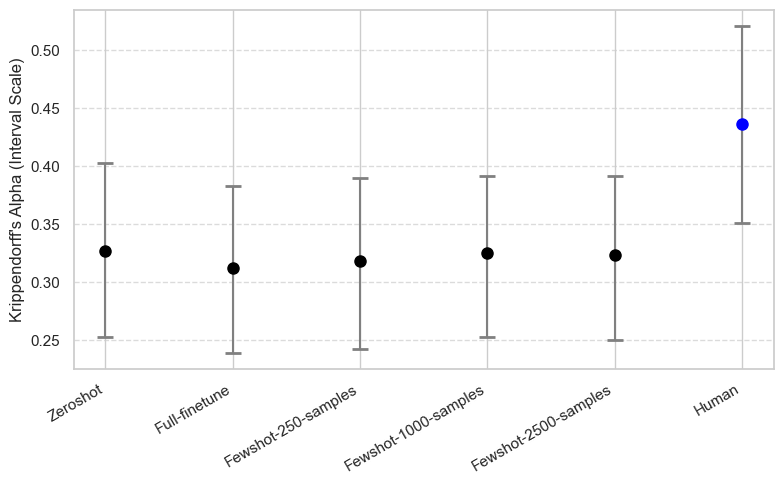

In [27]:
plot_CI(CI_data, model_names, title=None, ylabel="Krippendorff's Alpha (Interval Scale)")

___
## Comparing classes
We create pools for each annotation class, including all items where a specific class was annotated at least once.

In [28]:
agreement_pools = {}
for i in range(R):
    pool = [scores for scores in human_data["all"] if i in scores]
    agreement_pools[i] = (Mean_Squared_Diff(pool), K_alpha(pool,"interval"), K_alpha(pool,"nominal"))
                        
    print(pool)

agreement_pools

[[0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 2], [2, 1, 0, 2, 0, 0], [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 0, 1, 0, 1], [0, 1, 0, 0, 3, 0], [0, 2, 1, 2, 1, 3], [2, 2, 2, 0, 1, 3], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1], [0, 2, 0, 2, 0, 0], [0, 1, 0, 1, 0, 1], [3, 3, 2, 0, 0, 2], [0, 0, 0, 0, 0, 0], [2, 2, 1, 0, 1, 3], [1, 2, 0, 0, 0, 0], [2, 3, 1, 1, 0, 3], [4, 3, 2, 0, 0, 1], [0, 1, 0, 1, 0, 2], [0, 1, 0, 0, 0, 0], [1, 2, 0, 3, 2, 1], [0, 2, 3, 1, 1, 1], [0, 0, 0, 0, 0, 1], [3, 4, 1, 3, 2, 0], [0, 0, 0, 0, 0, 0], [0, 3, 1, 0, 1, 2], [0, 1, 0, 0, 1, 0], [2, 2, 0, 0, 1, 3], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [1, 2, 2, 0, 3, 1], [1, 2, 1, 1, 3, 0], [0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0], [1, 1, 3, 1, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 1, 2, 1, 0, 2], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1],

{0: (np.float64(1.1981981981981982),
  np.float64(0.22475),
  np.float64(0.07934703347696381)),
 1: (np.float64(1.3450980392156862),
  np.float64(0.3109921898740673),
  np.float64(0.08497435840388046)),
 2: (np.float64(1.851190476190476),
  np.float64(0.219932763797273),
  np.float64(0.009585953256614044)),
 3: (np.float64(2.25),
  np.float64(0.11471659747521812),
  np.float64(-0.03136084679916662)),
 4: (np.float64(2.5380952380952375),
  np.float64(-0.017105414415450104),
  np.float64(-0.025458629726694104))}

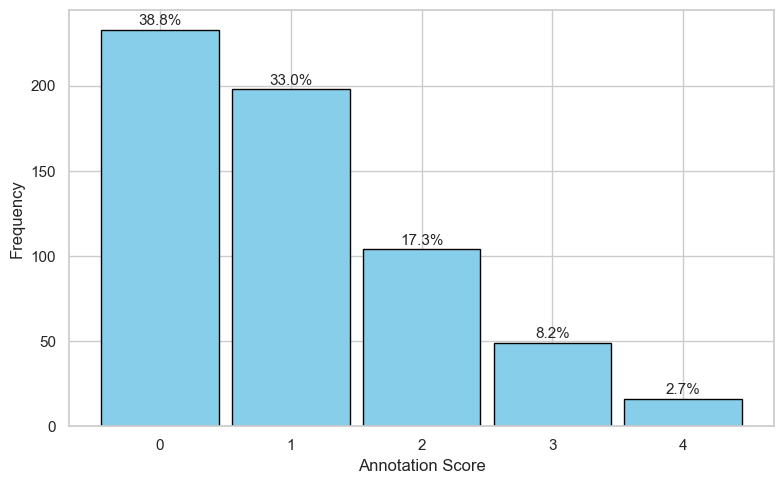

In [29]:
sns.set(style="whitegrid")

bins = [x - 0.5 for x in range(6)]

plt.figure(figsize=(8, 5))
counts, _, patches = plt.hist(all_scores, bins=bins, edgecolor='black', color='skyblue', rwidth=0.9)

# Add percentages above bars
total = sum(counts)
for count, patch in zip(counts, patches):
    if count > 0:
        height = patch.get_height()
        plt.text(patch.get_x() + patch.get_width() / 2, height + 1, f"{100 * count / total:.1f}%", 
                 ha='center', va='bottom', fontsize=11)

plt.xticks(range(5)) 
plt.xlabel('Annotation Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [36]:
# Displaying IDs with all scores from 0 to 4 (high disagreement)
ids_with_all_scores = [id_ for id_, scores in score_dict.items() if set([0, 1, 2, 3, 4]).issubset(set(scores))]
for id_ in ids_with_all_scores:
    print(f"ID: {id_}, Text: {df_mikkel['text'][df_mikkel['id'] == id_].values[0][:1000]}..." )
    print(f"Scores: {score_dict[id_]}")
    print("-" * 40)

ID: 9c41aa98-225a-436f-8fb9-cc2b6588085f, Text: Guzmania - Guzmania
Flerårige urteagtige stemløse planter, epifytter. Radikale blade, der danner en roset, lineær og xiphoid, hele. Peduncle dækket med små blade (forlader midten af roset af blade). Inflorescens spiciform eller panicle, nogle gange i form af et hoved. Blomsterne er placeret i axils af de røde bracts; corolla spongat, med segmenter kortere end røret; keglerne krydser i bunden.
Generelle oplysninger om anlægget Guzmania - Guzmania
Guzmania - Guzmania bromeliad familie.
Antal: I en slægt omkring 110 arter.
Oprindelsessted: Central- og Sydamerika.
Anvendelse: blomstring.
Plante størrelse: op til 30 cm i højden.
Vækst: langsom.
Blomstrende: om sommeren, efterår-vinter.
Guzmania arter - Guzmania
Guzmania lingulata var. Lingulata
Epifyter. Planter 40-45 cm høje. Bladene er bælteformede, 45 cm lange og op til 6 cm brede, bredere ved bunden, grøn over, bunden med rødbrune linjer, bar. Blomstring er et tæt hoved. Kronblade hvidlig;

In [31]:
def Mean_Ordinal_Diff(scores): # <— one item
    freqs = Counter(scores)
    categories = sorted(freqs.keys())
    total_pairs = 0
    total_OD = 0

    # Iterate over all unordered distinct pairs (a, b) where a < b
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            a, b = categories[i], categories[j]

            # Frequencies of a, b
            n_a = freqs[a]
            n_b = freqs[b]

            # Sum of frequencies between a and b (inclusive)
            n_sum = sum(freqs[g] for g in range(a, b + 1))

            # Ordinal difference formula
            delta_sq = (n_sum - (n_a + n_b) / 2) ** 2

            # Count how many such pairs exist
            pair_count = n_a * n_b
            total_OD += delta_sq * pair_count
            total_pairs += pair_count

    # Normalize by total number of unordered pairs
    if total_pairs > 0:
        return total_OD / total_pairs
    else:
        return 0